In [1]:
import os
import sys
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import random

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [3]:
## Test model

PATH_TO_GRAPH = r'models/real/24_batch/frozen_inference_graph.pb' ## load SSD trained on udacity's parking lot images
PATH_TO_LABELS = r'data/udacity_label_map.pbtxt'
NUM_CLASSES = 13

In [4]:
detection_graph = load_graph(PATH_TO_GRAPH)

In [5]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [6]:
IMAGE_SIZE = (12, 8)

SCORES
[0.00397144 0.00389333 0.0036266  0.00347493 0.00345131 0.00342834
 0.00335487 0.00333717 0.00331226 0.00326345]
CLASSES
[1. 2. 3. 2. 3. 3. 2. 1. 1. 4.]


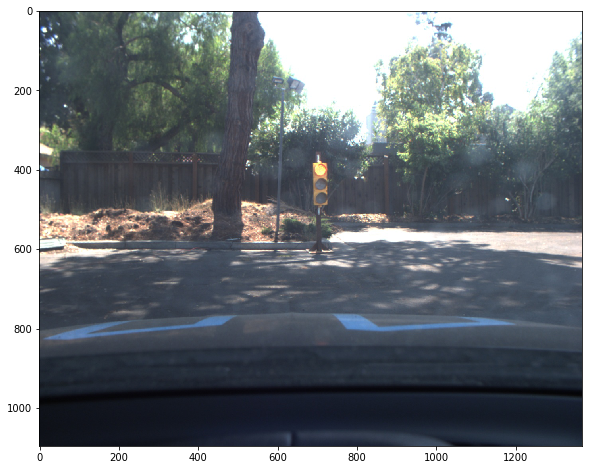

SCORES
[0.00536062 0.0037953  0.00364675 0.00347166 0.00335232 0.00333195
 0.00327742 0.00325841 0.00324663 0.00324185]
CLASSES
[1. 4. 4. 2. 4. 4. 4. 4. 1. 2.]


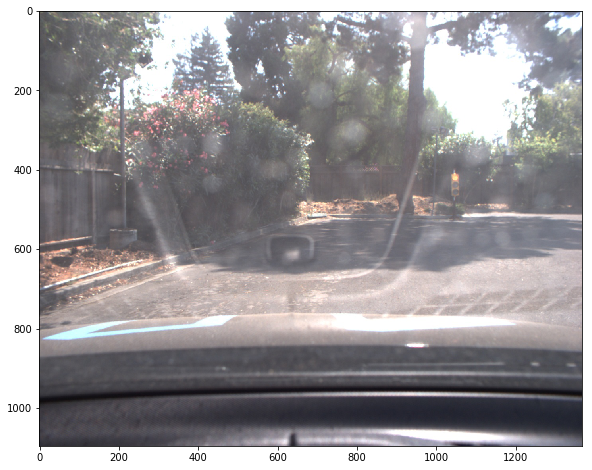

SCORES
[0.99741566 0.00526265 0.00504053 0.00440186 0.00429263 0.00407173
 0.0038139  0.0037963  0.00377648 0.00365507]
CLASSES
[1. 2. 4. 4. 4. 3. 4. 4. 3. 2.]


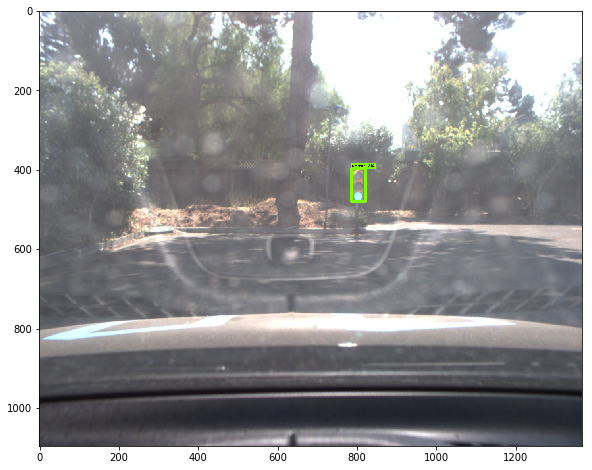

SCORES
[0.00510376 0.00408693 0.00398447 0.00389803 0.00386338 0.00366765
 0.00365537 0.00353648 0.00341078 0.00338968]
CLASSES
[4. 1. 4. 4. 4. 4. 4. 2. 2. 3.]


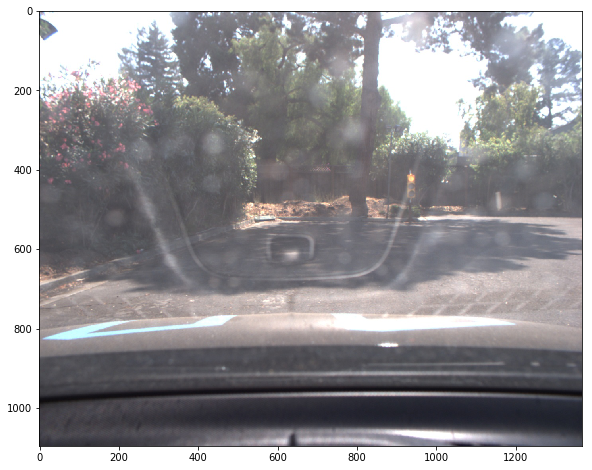

SCORES
[0.00818465 0.00487498 0.00467183 0.00426567 0.00388491 0.00351005
 0.00345313 0.0033847  0.00331868 0.00327688]
CLASSES
[1. 4. 4. 4. 4. 2. 4. 4. 3. 2.]


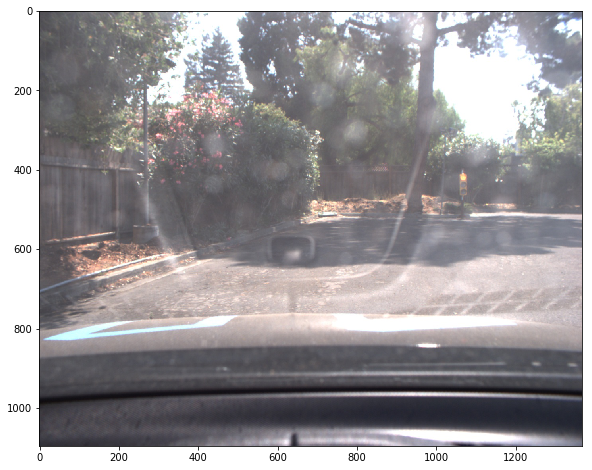

SCORES
[0.01009761 0.00439306 0.00391262 0.0036953  0.00334968 0.00334356
 0.00325195 0.00322572 0.00320668 0.00318646]
CLASSES
[1. 1. 3. 2. 4. 1. 4. 2. 3. 4.]


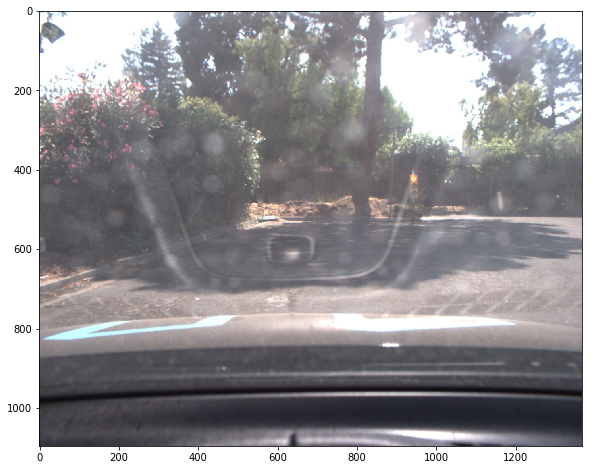

SCORES
[0.9918926  0.00593852 0.00439256 0.00412318 0.00410392 0.004097
 0.00402886 0.00388593 0.00376876 0.0034847 ]
CLASSES
[1. 2. 2. 2. 2. 4. 3. 1. 3. 2.]


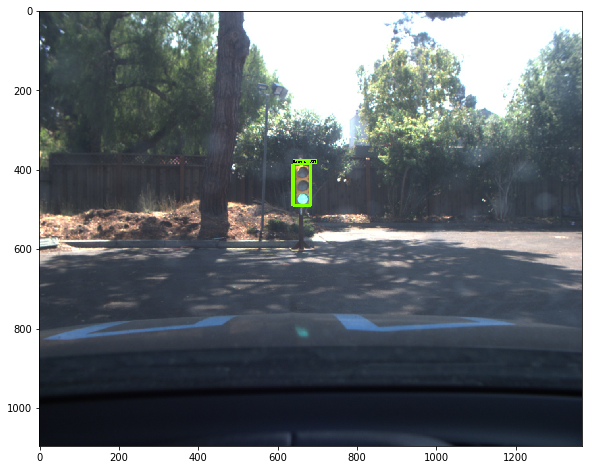

SCORES
[0.00454213 0.00429485 0.00406969 0.00394258 0.00385048 0.00378588
 0.0036258  0.00345435 0.00337516 0.00318936]
CLASSES
[4. 3. 4. 3. 4. 4. 3. 2. 2. 1.]


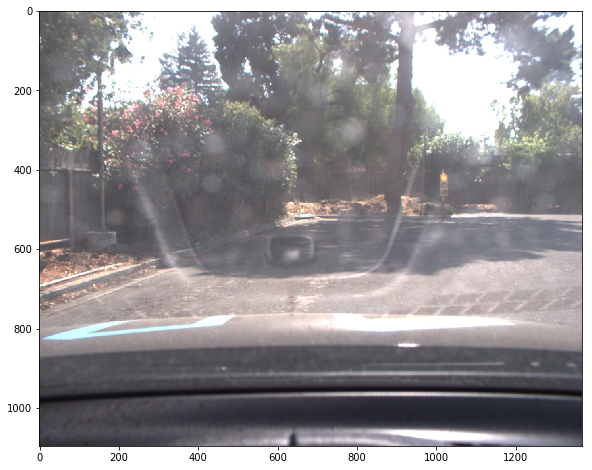

SCORES
[0.00684417 0.00411956 0.00409    0.00389842 0.00370023 0.00361531
 0.00350705 0.00342305 0.00318839 0.00316436]
CLASSES
[1. 3. 4. 1. 1. 2. 4. 3. 4. 3.]


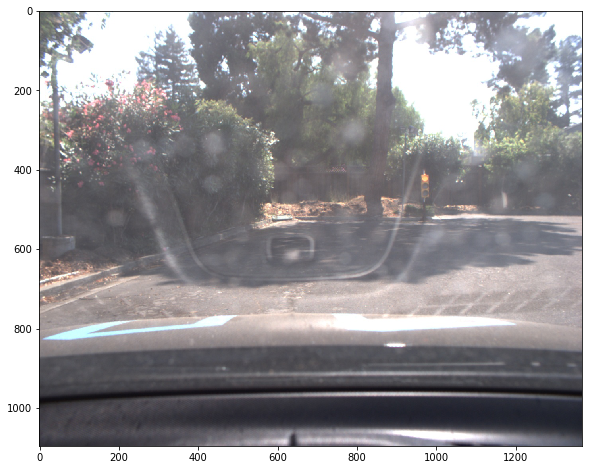

SCORES
[0.8821276  0.00507177 0.00448943 0.00409619 0.00405243 0.00402879
 0.0037375  0.00366712 0.00365953 0.00358139]
CLASSES
[1. 3. 2. 4. 2. 3. 3. 4. 3. 3.]


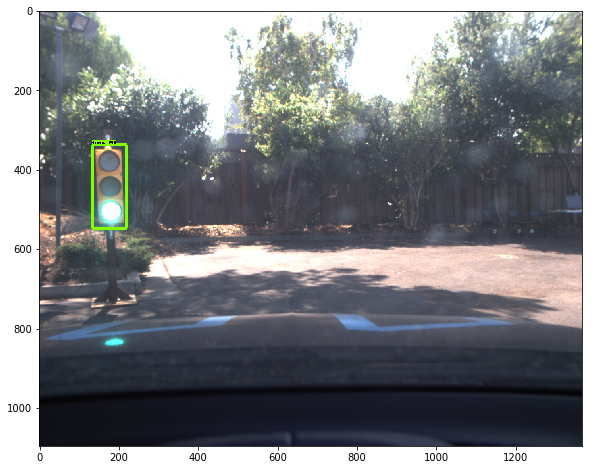

SCORES
[0.9846144  0.00442016 0.00427265 0.00395392 0.00394015 0.0036733
 0.00366574 0.00365825 0.00361337 0.00358712]
CLASSES
[1. 3. 2. 3. 4. 3. 3. 4. 2. 1.]


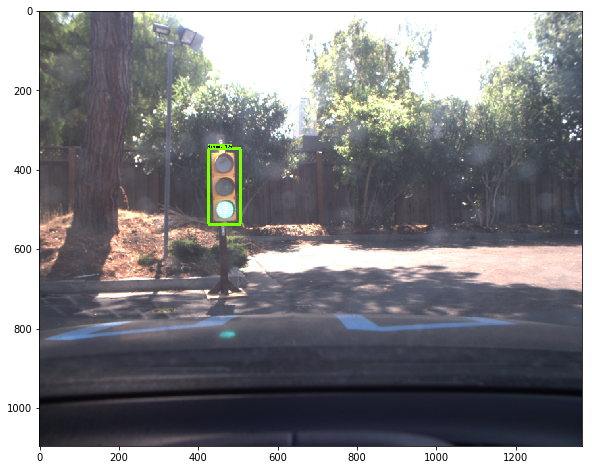

In [7]:
PATH_TO_IMGS = r'data/udacity_testarea_rgb'
TEST_IMGS = glob(os.path.join(PATH_TO_IMGS, r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            random.shuffle(TEST_IMGS)
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break